In [ ]:
#hide
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#hide
%load_ext autoreload 
%autoreload 2
%cd "/content/drive/MyDrive/Coding/ModelAssistedLabel"

/content/drive/MyDrive/Coding/ModelAssistedLabel


In [ ]:
#hide
%run '_Synch.ipynb' 

/content/drive/MyDrive/Coding/ModelAssistedLabel
install nbdev: y
git commit -m: regenerate api token
Converted 00_config.ipynb.
Converted 01_split.ipynb.
Converted 02_train.ipynb.
Converted index.ipynb.
converting: /content/drive/My Drive/Coding/ModelAssistedLabel/index.ipynb
converting /content/drive/My Drive/Coding/ModelAssistedLabel/index.ipynb to README.md
Executing: git config --local include.path ../.gitconfig
Success: hooks are installed and repo's .gitconfig is now trusted



# Model-asisted Labeling with YOLOv5

Background
---

Object Detection is great! ... if your labeled dataset already exists. I wanted to use machine learning to turn my regular rowing machine into a "smart" rowing machine (specifically: I want to track my workout stats).

Unfortunately, I was unable to find a suitable existing set of labeled LCD digits.

After working through [a Roboflow tutorial]( https://models.roboflow.com/object-detection/yolov5), I started to use Roboflow to annotate and store my images. 

I hated annotating my images by hand. Once my model began making reasonable guesses, I resolved to enlist the model's help in labeling new images. (I ended up building a [key-driven image labeler](https://github.com/PhilBrockman/autobbox) to modify my model's predictions, but that codebase is no longer being maintained.)

---

## Expected Inputs:
* **Labeled data** (for the model):
  - All of the images and labels must be in a common folder (subfolders allowed).
  - labels must be in [YOLOv5 format](https://github.com/AlexeyAB/Yolo_mark/issues/60).
* **Unlabeled Data**:
  - Hopefully similar enough to the labeled data that the model will be of assistance in labeling.


> Note about file names: Pairs are based on sharing a base filename. For example `image.jpg/image.txt` would be paired as would `other_image5.jpg/other_image5.txt`.



## Expected Output:

* ***ZIP file*** that contains: 
    - `images/`
      + a copy of every image in **Unlabeled Data**
    - `labels/` (folder
      + result of running object detection on each image
    - a results folder produced by Ultralytic's `train.p` on the **Labeled Data**
    - `classmap.yaml` to preserve the identity of the classes



In [ ]:
!git add -u .
!git commit -m "move down"
!git push

[master 69e0481] move down
Counting objects: 25, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (25/25), done.
Writing objects: 100% (25/25), 5.77 KiB | 328.00 KiB/s, done.
Total 25 (delta 20), reused 0 (delta 0)
remote: Resolving deltas: 100% (20/20), completed with 8 local objects.
To https://github.com/PhilBrockman/ModelAssistedLabel.git
   53079b2..69e0481  master -> master


# Preparing Repository

Start by cloning https://github.com/ultralytics/yolov5.

In [ ]:
#hide
%run "_Synch.ipynb"

In [ ]:
from ModelAssistedLabel.core import Defaults

os.chdir(Defaults().root)
Defaults.prepare_YOLOv5()

Setup complete. Using torch 1.8.0+cu101 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16160MB, multi_processor_count=80)


# Image Sets

### Vanilla image sets

Recursively search a folder (`repo`) that contains images and labels.

In [ ]:
wm.__cleanup__()

In [ ]:
repo = "/content/drive/MyDrive/Coding/Roboflow Export (841)"
name = "nospaces"
wm = AutoWeights(repo, name)

summary:  [{'train': 4}, {'valid': 1}, {'test': 0}]
checksum: 5
target/dest /content/drive/MyDrive/Coding/Roboflow Export (841)/images/digittake-52-jpg_jpg.rf.798cf1dcc7a60cbff6c43f5587082f4f.jpg | ./train/images/digittake-52-jpg_jpg.rf.798cf1dcc7a60cbff6c43f5587082f4f.jpg
target/dest /content/drive/MyDrive/Coding/Roboflow Export (841)/labels/digittake-52-jpg_jpg.rf.798cf1dcc7a60cbff6c43f5587082f4f.txt | ./train/labels/digittake-52-jpg_jpg.rf.798cf1dcc7a60cbff6c43f5587082f4f.txt
target/dest /content/drive/MyDrive/Coding/Roboflow Export (841)/images/save_dirrsave_dirrcd4d249fd27369f927124e67151b8d97e4bdfdd4-jpg-jpg_jpg.rf.5659d1ef98ace2d9f22fa90d114bf7d6.jpg | ./train/images/save_dirrsave_dirrcd4d249fd27369f927124e67151b8d97e4bdfdd4-jpg-jpg_jpg.rf.5659d1ef98ace2d9f22fa90d114bf7d6.jpg
target/dest /content/drive/MyDrive/Coding/Roboflow Export (841)/labels/save_dirrsave_dirrcd4d249fd27369f927124e67151b8d97e4bdfdd4-jpg-jpg_jpg.rf.5659d1ef98ace2d9f22fa90d114bf7d6.txt | ./train/labels/save_di

In [ ]:
%%time
wm.generate_weights(10)

CPU times: user 2.02 ms, sys: 23.9 ms, total: 25.9 ms
Wall time: 30.9 s


'./nospaces4-025678'

In [ ]:
  !ls "{wm.last_results_path}"

confusion_matrix.png				    results.txt
events.out.tfevents.1615931373.99e938482867.3591.0  test_batch0_labels.jpg
hyp.yaml					    test_batch0_pred.jpg
labels_correlogram.jpg				    train_batch0.jpg
labels.jpg					    train_batch1.jpg
opt.yaml					    train_batch2.jpg
results.png					    weights


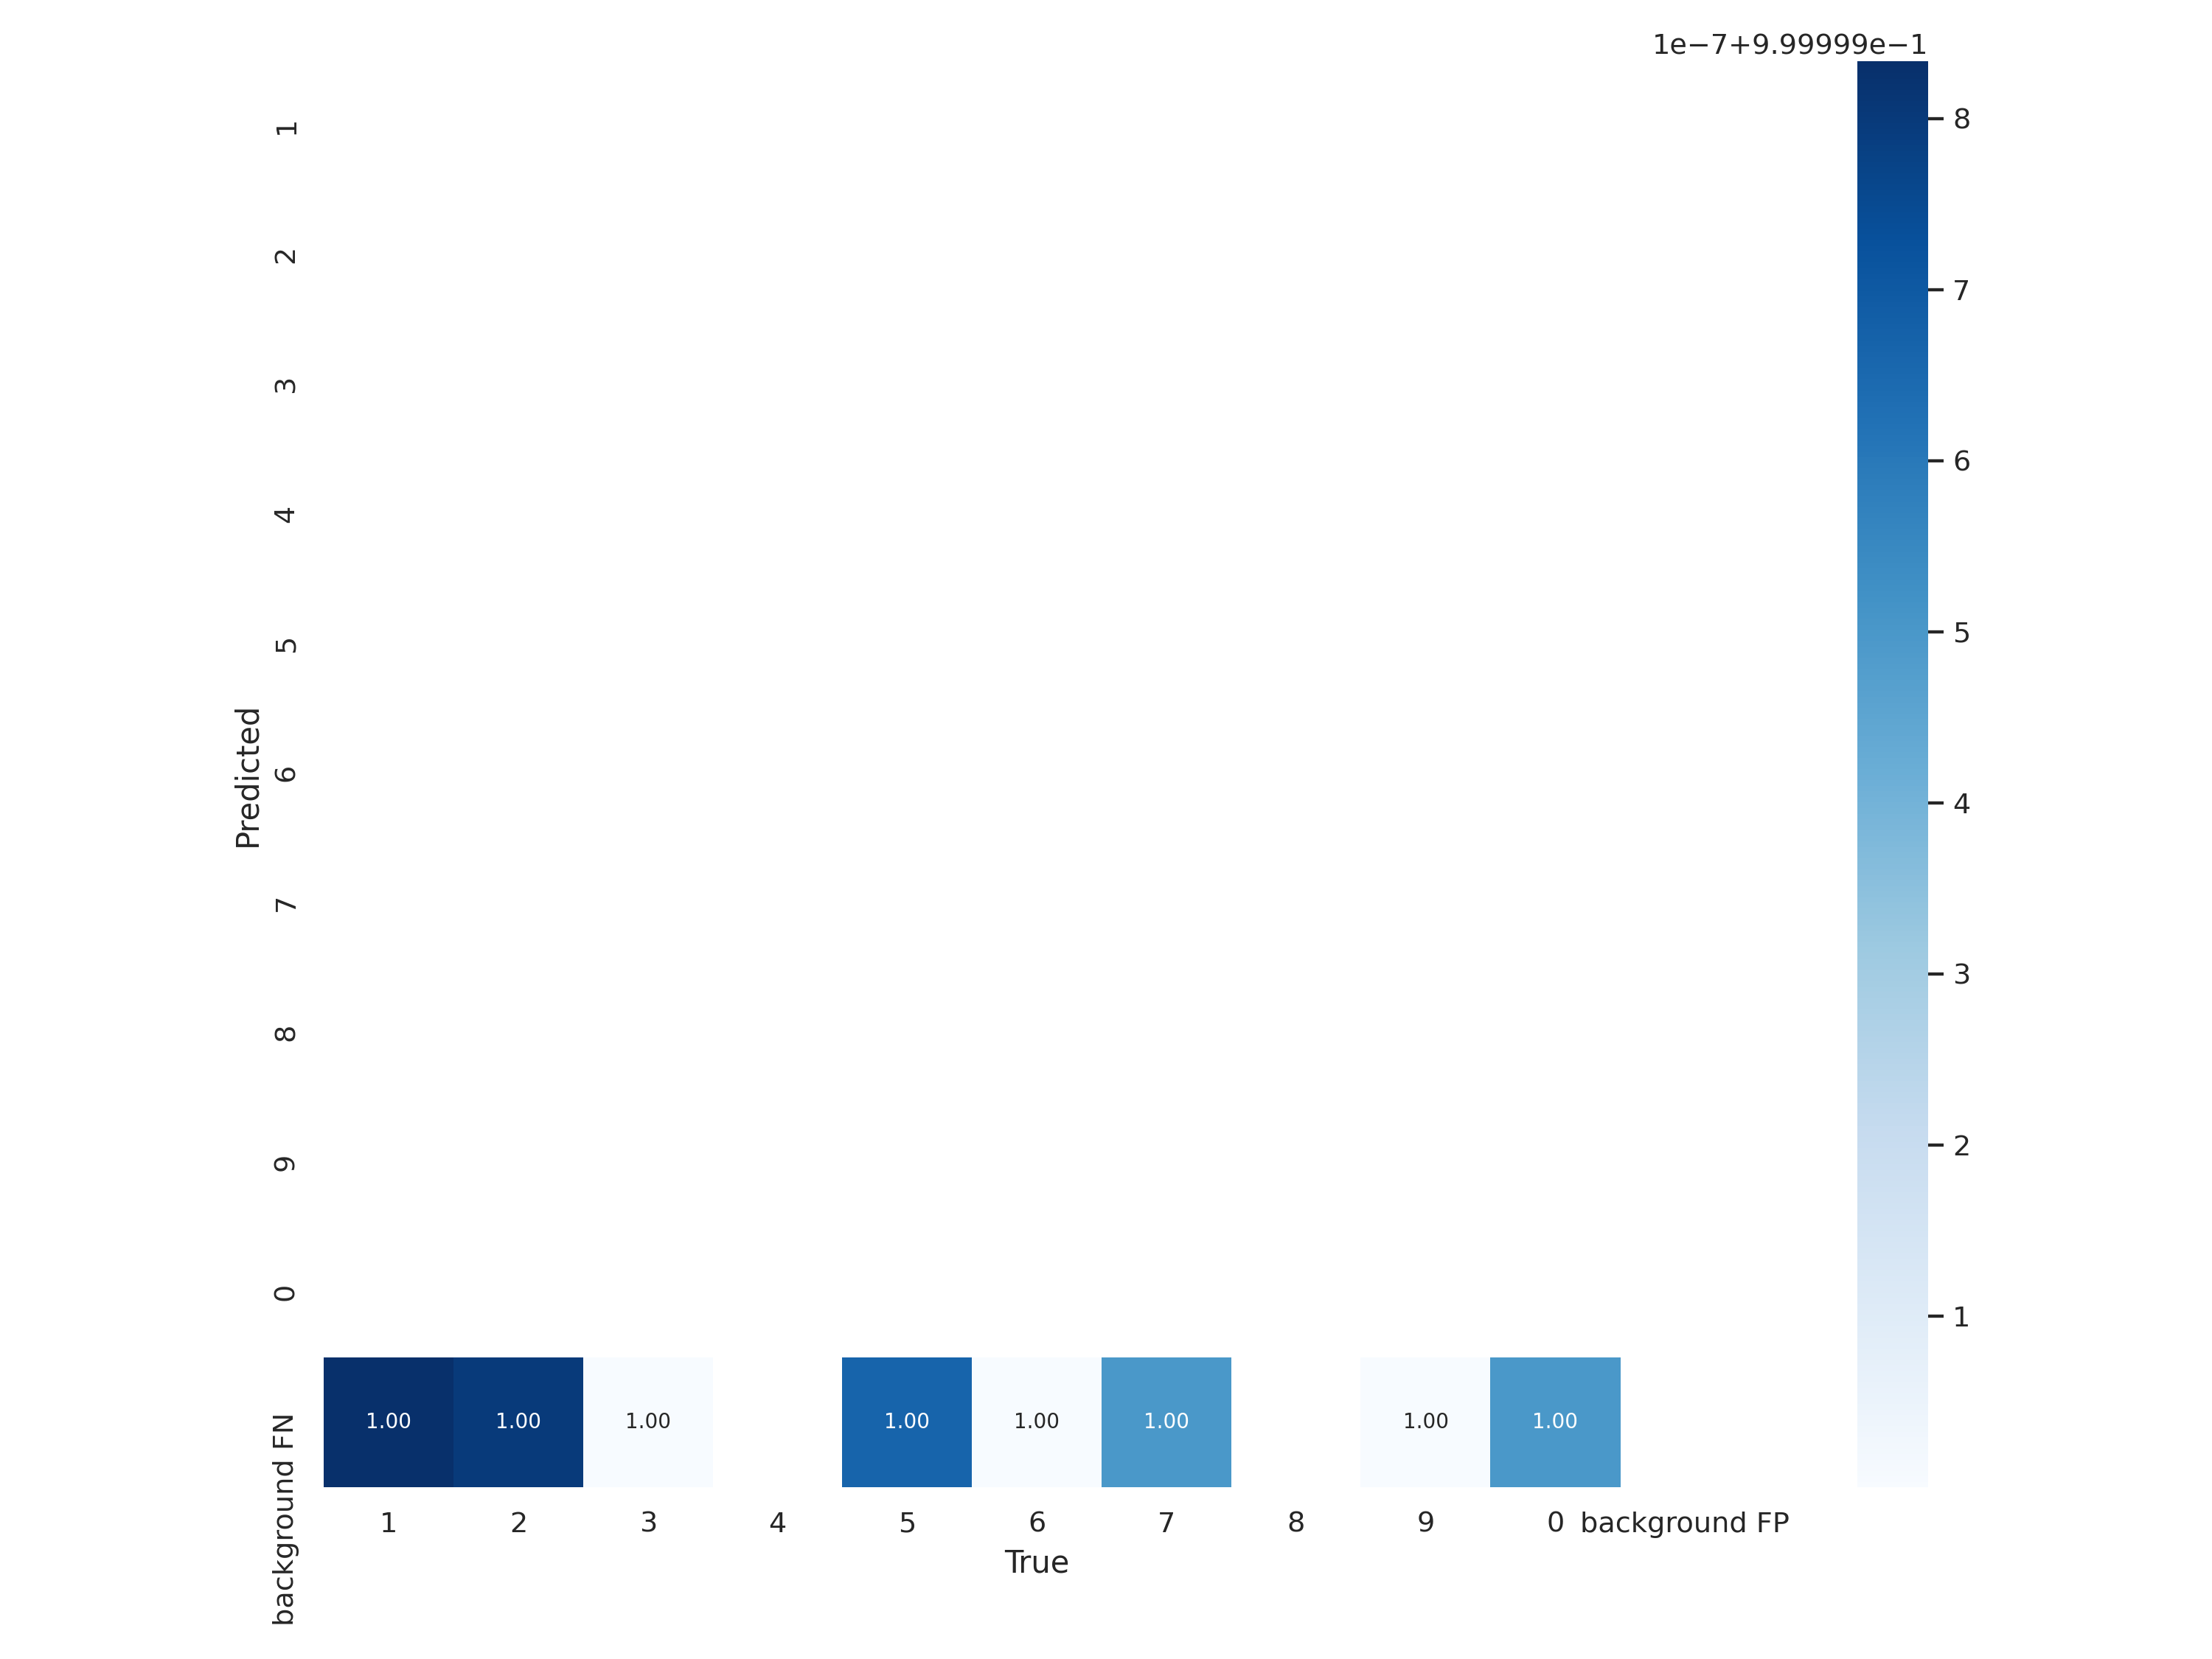

In [ ]:
import PIL
PIL.Image.open(f"{wm.last_results_path}/confusion_matrix.png")

In [ ]:
ls

 00_config.ipynb         ModelAssistedLabel/
 01_split.ipynb          nospaces4-025678/
 02_train.ipynb          README.md
 03_make_weights.ipynb  'Roboflow Export (841)nospaces 21-03-16 21-34-54'/
 CONTRIBUTING.md         settings.ini
 docker-compose.yml      setup.py
 docs/                   _Synch.ipynb
 index.ipynb            'train (1)'/
 LICENSE                'train (2)'/
 Makefile                yolov5/
 MANIFEST.in


### Augmenting an image set